In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split




In [ ]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/ComputerVision/CelebA-HQ-img-5000 (2).zip'

Archive:  /content/drive/MyDrive/ComputerVision/CelebA-HQ-img-5000 (2).zip
   creating: CelebA-HQ-img-5000/
  inflating: CelebA-HQ-img-5000/0.jpg  
  inflating: CelebA-HQ-img-5000/1.jpg  
  inflating: CelebA-HQ-img-5000/10.jpg  
  inflating: CelebA-HQ-img-5000/100.jpg  
  inflating: CelebA-HQ-img-5000/1000.jpg  
  inflating: CelebA-HQ-img-5000/1001.jpg  
  inflating: CelebA-HQ-img-5000/1002.jpg  
  inflating: CelebA-HQ-img-5000/1003.jpg  
  inflating: CelebA-HQ-img-5000/1004.jpg  
  inflating: CelebA-HQ-img-5000/1005.jpg  
  inflating: CelebA-HQ-img-5000/1006.jpg  
  inflating: CelebA-HQ-img-5000/1007.jpg  
  inflating: CelebA-HQ-img-5000/1008.jpg  
  inflating: CelebA-HQ-img-5000/1009.jpg  
  inflating: CelebA-HQ-img-5000/101.jpg  
  inflating: CelebA-HQ-img-5000/1010.jpg  
  inflating: CelebA-HQ-img-5000/1011.jpg  
  inflating: CelebA-HQ-img-5000/1012.jpg  
  inflating: CelebA-HQ-img-5000/1013.jpg  
  inflating: CelebA-HQ-img-5000/1014.jpg  
  inflating: CelebA-HQ-img-5000/1015.jpg  

In [ ]:
!unzip '/content/drive/MyDrive/ComputerVision/CelebA-HQ-mask-5000 (2).zip'

Archive:  /content/drive/MyDrive/ComputerVision/CelebA-HQ-mask-5000 (2).zip
   creating: CelebA-HQ-mask-5000/
  inflating: CelebA-HQ-mask-5000/00000_hair.png  
  inflating: CelebA-HQ-mask-5000/00001_hair.png  
  inflating: CelebA-HQ-mask-5000/00010_hair.png  
  inflating: CelebA-HQ-mask-5000/00011_hair.png  
  inflating: CelebA-HQ-mask-5000/00012_hair.png  
  inflating: CelebA-HQ-mask-5000/00013_hair.png  
  inflating: CelebA-HQ-mask-5000/00014_hair.png  
  inflating: CelebA-HQ-mask-5000/00015_hair.png  
  inflating: CelebA-HQ-mask-5000/00100_hair.png  
  inflating: CelebA-HQ-mask-5000/00101_hair.png  
  inflating: CelebA-HQ-mask-5000/00102_hair.png  
  inflating: CelebA-HQ-mask-5000/00103_hair.png  
  inflating: CelebA-HQ-mask-5000/00104_hair.png  
  inflating: CelebA-HQ-mask-5000/00105_hair.png  
  inflating: CelebA-HQ-mask-5000/00106_hair.png  
  inflating: CelebA-HQ-mask-5000/00107_hair.png  
  inflating: CelebA-HQ-mask-5000/00108_hair.png  
  inflating: CelebA-HQ-mask-5000/00109_h

In [ ]:
def count_files(folder_path):
  """Counts the number of files in a folder.

  Args:
    folder_path: The path to the folder.

  Returns:
    The number of files in the folder.
  """
  file_count = 0
  for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    if os.path.isfile(item_path):
      file_count += 1
  return file_count


In [ ]:
# Set Paths
IMAGE_DIR = "/content/CelebA-HQ-img-5000"
MASK_DIR = "/content/CelebA-HQ-mask-5000"

# Image and Mask Dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 6  # Number of segmentation classes (e.g., skin, hair, eyes, etc.)



In [ ]:
file_count = count_files(IMAGE_DIR)
print(f"Number of files in '{IMAGE_DIR}': {file_count}")

Number of files in '/content/CelebA-HQ-img-5000': 561


In [ ]:
file_count = count_files(MASK_DIR)
print(f"Number of files in '{MASK_DIR}': {file_count}")

Number of files in '/content/CelebA-HQ-mask-5000': 562


In [ ]:
# prompt: extract number from 0.jpg

import re

def extract_number(filename):
  """
  Extracts the number from a filename like "0.jpg".

  Args:
    filename: The filename string.

  Returns:
    The extracted number as an integer, or None if no number is found.
  """
  match = re.search(r"(\d+)", filename)
  if match:
    return int(match.group(1))
  return None

# Example usage
filename = "0.jpg"
number = extract_number(filename)
if number is not None:
    print(f"The number extracted from '{filename}' is: {number}")
else:
    print(f"No number found in '{filename}'")


The number extracted from '0.jpg' is: 0


In [ ]:
# Modified load_data function to yield batches and handle potential errors
def load_data(image_dir, mask_dir, batch_size=32, test_data=False, test_size=0.2, random_state=42):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Split into train and test sets if requested
    if test_data:
      _, test_image_files, _, test_mask_files = train_test_split(
          image_files, mask_files, test_size=test_size, random_state=random_state
      )
      image_files = test_image_files
      mask_files = test_mask_files

    num_samples = len(image_files)

    for i in range(0, num_samples, batch_size):
        batch_images, batch_masks = [], []
        for j in range(i, min(i + batch_size, num_samples)):
            img_name = image_files[j]

            # Extract image number and construct mask filename
            filenumber = extract_number(img_name)
            image_number = str(filenumber).zfill(5)
            mask_name = image_number + "_hair.png"

            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, mask_name)

            if not os.path.exists(mask_path):
                print(f"Mask file not found for image: {image_number}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0  # Normalize

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Error reading mask: {mask_path}")
                continue
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            mask = (mask / 255 * (NUM_CLASSES - 1)).astype(np.uint8)
            mask = to_categorical(mask, NUM_CLASSES)

            batch_images.append(img)
            batch_masks.append(mask)

        yield np.array(batch_images), np.array(batch_masks)



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(u5)
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(u6)
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(u7)
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(c7)

    return Model(inputs, outputs)

# Checkpoint to save the model with the best validation accuracy
checkpoint_filepath = '/content/drive/MyDrive/Computer_Vision/best_model_5000.h5' # Save in your drive
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',              # Save the model with the maximum validation accuracy
    save_best_only=True     # Save only the best model
)

# Compile U-Net model
model = unet_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,697,670 (29.36 MB)

 Trainable params: 7,697,670 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training with batches
EPOCHS = 20
BATCH_SIZE = 32

history = model.fit(
    load_data(IMAGE_DIR, MASK_DIR, batch_size=BATCH_SIZE),  # Use the generator
    steps_per_epoch=len(os.listdir(IMAGE_DIR)) // BATCH_SIZE, # Number of batches per epoch
    validation_data=load_data(IMAGE_DIR, MASK_DIR, batch_size=BATCH_SIZE), # Validation data generator
    validation_steps=len(os.listdir(IMAGE_DIR)) // BATCH_SIZE // 5, # Validation steps
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, early_stopping]
)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5064 - loss: 1.3626

17/17 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.5113 - loss: 1.3487 - val_accuracy: 0.6584 - val_loss: 0.8408
Epoch 2/20
 1/17 ━━━━━━━━━━━━━━━━━━━━ 15:36 59s/step - accuracy: 0.6369 - loss: 0.8595

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.6369 - loss: 0.8595 - val_accuracy: 0.6626 - val_loss: 0.7927
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.6722 - loss: 0.7752 - val_accuracy: 0.6493 - val_loss: 0.8112
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step - accuracy: 0.6722 - loss: 0.7696 - val_accuracy: 0.6600 - val_loss: 0.7580
Epoch 5/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6630 - loss: 0.7449

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 326ms/step - accuracy: 0.6722 - loss: 0.7281 - val_accuracy: 0.6633 - val_loss: 0.6989
Epoch 6/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6630 - loss: 0.7007

17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6722 - loss: 0.6895 - val_accuracy: 0.6657 - val_loss: 0.6739
Epoch 7/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6630 - loss: 0.6653

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.6722 - loss: 0.6549 - val_accuracy: 0.6734 - val_loss: 0.6250
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.6722 - loss: 0.6183 - val_accuracy: 0.6734 - val_loss: 0.5932
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6722 - loss: 0.5898 - val_accuracy: 0.6733 - val_loss: 0.5748
Epoch 10/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.6721 - loss: 0.5727 - val_accuracy: 0.6734 - val_loss: 0.5621
Epoch 11/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.6721 - loss: 0.5612 - val_accuracy: 0.6730 - val_loss: 0.5552
Epoch 12/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 0.6711 - loss: 0.5564 - val_accuracy: 0.6727 - val_loss: 0.5498
Epoch 13/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.6714 - loss: 0.5496 - val_accuracy: 0.6729 - val_loss: 0.5465
Epoch 14/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.6718 - loss: 0.5497 - val_accuracy: 0.6730 -

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.6851 - loss: 0.5447 - val_accuracy: 0.7015 - val_loss: 0.5286
Epoch 18/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.6999 - loss: 0.5269 - val_accuracy: 0.6929 - val_loss: 0.5292
Epoch 19/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6922 - loss: 0.5341

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.7045 - loss: 0.5346 - val_accuracy: 0.7096 - val_loss: 0.5217
Epoch 20/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7065 - loss: 0.5220

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.7147 - loss: 0.5205 - val_accuracy: 0.7368 - val_loss: 0.5121


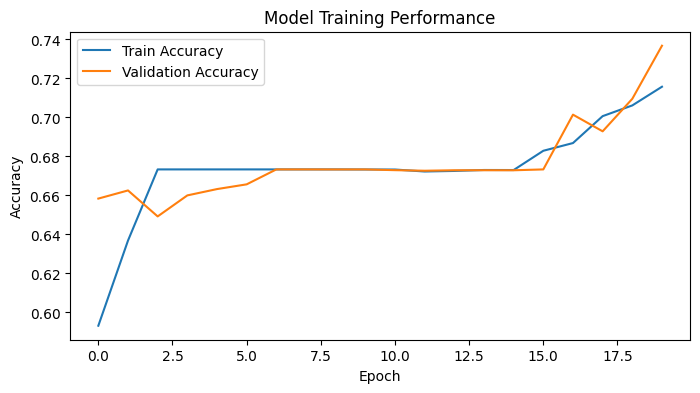

In [ ]:
# Plot Training History
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Training Performance')
plt.show()


#Deeplab

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, UpSampling2D,
                                     BatchNormalization, Activation, Concatenate)

def deeplabv3plus(input_size=(256, 256, 3), num_classes=6):
    inputs = Input(input_size)

    # Load ResNet50 Backbone
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Extract feature maps
    x = base_model.get_layer('conv4_block6_out').output  # (32, 32, 1024)

    # ASPP Module (Atrous Spatial Pyramid Pooling)
    x = Conv2D(256, (3, 3), dilation_rate=(6, 6), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), dilation_rate=(12, 12), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), dilation_rate=(18, 18), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Upsample ASPP output to match low-level features
    x = UpSampling2D(size=(4, 4), interpolation='bilinear')(x)  # Now (128, 128, 256)

    # Extract low-level features from early layers
    low_level_features = base_model.get_layer('conv2_block3_out').output  # (128, 128, 256)

    # Concatenation of ASPP output and low-level features
    x = Concatenate()([x, low_level_features])  # Both are now (128, 128, 512)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # **Fix: Upsample to (256, 256, 256)**
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # (256, 256, 256)

    # **Fix: Use Conv2DTranspose for better upsampling**
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)  # (256, 256, 256)

    # Final output layer with softmax
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # (256, 256, num_classes)

    return Model(inputs, outputs)

# Create model
model = deeplabv3plus()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 13,904,518 (53.04 MB)

 Trainable params: 13,871,878 (52.92 MB)

 Non-trainable params: 32,640 (127.50 KB)

In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),  # Change this line
    metrics=['accuracy']
)

# Define callbacks
checkpoint = ModelCheckpoint("deeplabv3_model.h5", save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
     load_data(IMAGE_DIR, MASK_DIR, batch_size=BATCH_SIZE),  # Use the generator
    steps_per_epoch=len(os.listdir(IMAGE_DIR)) // BATCH_SIZE,  # Number of batches per epoch
    validation_data=load_data(IMAGE_DIR, MASK_DIR, batch_size=BATCH_SIZE),  # Validation data generator
    validation_steps=len(os.listdir(IMAGE_DIR)) // BATCH_SIZE // 5,  # Validation steps
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping]  # Use correct callback variables
)



Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7739 - loss: 0.7331

17/17 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7795 - loss: 0.7152 - val_accuracy: 0.6584 - val_loss: 5.4437
Epoch 2/20
 1/17 ━━━━━━━━━━━━━━━━━━━━ 14:02 53s/step - accuracy: 0.9206 - loss: 0.1993

17/17 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - accuracy: 0.9206 - loss: 0.1993 - val_accuracy: 0.6675 - val_loss: 4.9045
Epoch 3/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9517 - loss: 0.1269   

17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 267ms/step - accuracy: 0.9477 - loss: 0.1348 - val_accuracy: 0.6694 - val_loss: 4.3028
Epoch 4/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9607 - loss: 0.1043 

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.9591 - loss: 0.1074 - val_accuracy: 0.6493 - val_loss: 4.2409
Epoch 5/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9647 - loss: 0.0896

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - accuracy: 0.9644 - loss: 0.0907 - val_accuracy: 0.6661 - val_loss: 3.9318
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.9678 - loss: 0.0802 - val_accuracy: 0.6528 - val_loss: 3.9842
Epoch 7/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9720 - loss: 0.0692

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.9718 - loss: 0.0694 - val_accuracy: 0.6677 - val_loss: 3.5846
Epoch 8/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9744 - loss: 0.0630

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9744 - loss: 0.0628 - val_accuracy: 0.6734 - val_loss: 3.3286
Epoch 9/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9760 - loss: 0.0591

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.9763 - loss: 0.0581 - val_accuracy: 0.6734 - val_loss: 3.2651
Epoch 10/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9785 - loss: 0.0531

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9789 - loss: 0.0522 - val_accuracy: 0.6734 - val_loss: 3.2632
Epoch 11/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9801 - loss: 0.0490

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.9804 - loss: 0.0483 - val_accuracy: 0.6734 - val_loss: 3.2318
Epoch 12/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9815 - loss: 0.0457

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9817 - loss: 0.0451 - val_accuracy: 0.6734 - val_loss: 3.1563
Epoch 13/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9830 - loss: 0.0421

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.9832 - loss: 0.0416 - val_accuracy: 0.6734 - val_loss: 3.0708
Epoch 14/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9840 - loss: 0.0395

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.9842 - loss: 0.0391 - val_accuracy: 0.6734 - val_loss: 3.0113
Epoch 15/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9851 - loss: 0.0370

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.9852 - loss: 0.0367 - val_accuracy: 0.6734 - val_loss: 2.9661
Epoch 16/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9859 - loss: 0.0349

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - accuracy: 0.9860 - loss: 0.0346 - val_accuracy: 0.6734 - val_loss: 2.9143
Epoch 17/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9866 - loss: 0.0332

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.9867 - loss: 0.0329 - val_accuracy: 0.6734 - val_loss: 2.8634
Epoch 18/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9874 - loss: 0.0315

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.9875 - loss: 0.0312 - val_accuracy: 0.6734 - val_loss: 2.8128
Epoch 19/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9881 - loss: 0.0299 

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9881 - loss: 0.0297 - val_accuracy: 0.6734 - val_loss: 2.7752
Epoch 20/20
 2/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.9886 - loss: 0.0286

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9887 - loss: 0.0284 - val_accuracy: 0.6734 - val_loss: 2.7688
